In [ ]:
import pandas as pd
from openai import OpenAI
import time

client = OpenAI(api_key="___")  # Replace ___ with your actual API key

#Run all of the CSVs through the OPENAI classifier to categorize each article as whether it's national, international, or irrelevant.
df = pd.read_csv("...csv")

def classify_article(title, content):
    if pd.isna(title) or pd.isna(content):
        return "Irrelevant"
    
    messages = [
        {
            "role": "system",
            "content": (
                "You are an expert research assistant supporting an academic study on blockchain and cryptocurrency adoption in Vietnam. "
                "Your task is to classify whether a news article is (1) relevant national Vietnamese news, (2) international/global news, or (3) irrelevant. "
                "The study analyzes how public sentiment and local developments influence Vietnam's blockchain economy, infrastructure, regulation, and financial landscape."
            )
        },
        {
            "role": "user",
            "content": f"""
Given the following article, classify it as:
• National — The article focuses on Vietnam’s blockchain ecosystem, government policy or regulation, local tech companies, domestic crypto exchanges, Vietnamese blockchain startups, Vietnam’s economic impact from crypto or blockchain, or local adoption/use cases.
• International — The article mainly discusses non-Vietnam-related topics such as crypto prices, foreign policy, international regulations, global companies, trends in other countries, or blockchain adoption abroad.
• Irrelevant — The article is off-topic, such as individual personal loss, general investment advice without Vietnamese context, pure speculation without any grounding, or any story not meaningful for Vietnam’s economic or technological environment.
Return just **one word** from these three: National, International, or Irrelevant.

Title: {title}

Content: {content}
"""
        }
    ]

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=0.3,
            max_tokens=20
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("Error:", e)
        return "Irrelevant"

categories = []

# Iterate with an index so you can print progress
for idx, row in enumerate(df.itertuples(), start=1):
    print(f"Processing row {idx}/{len(df)}…", end="\r") # \r to overwrite the same line
    cat = classify_article(row.title, row.content)
    categories.append(cat)
    time.sleep(0.1) 

df['category'] = categories
desired_order = ['category', 'title', 'url', 'date', 'content', 'vn_sent', 'vn_score']
df = df[desired_order]
df.to_csv("...csv", index=False)


In [ ]:
# Comparing the sentiment analysis results between Vietnamese and English versions
# ONLY applicable for CryptoBERT and FinBERT models
# An additional column will be inserted to measure the difference in sentiment scores between the two languages

from tabulate import tabulate
import pandas as pd

df_vn = pd.read_csv("...csv")
df_en = pd.read_csv("...csv")

df_compare = pd.DataFrame({
    "vn_sent": df_vn["sentiment"],
    "vn_score": df_vn["score"],
    "en_sent": df_en["sentiment"],
    "en_score": df_en["score"],
})
df_compare["diff_score"] = round((df_compare["en_score"] - df_compare["vn_score"]), 4)
df_compare["date"] = df_vn["date"]
df_compare["url"] = df_vn["url"]
df_compare["title_vn"] = df_vn["title"]
df_compare["content_vn"] = df_vn["content"]
df_compare["title_en"] = df_en["title_en"]
df_compare["content_en"] = df_en["content_en"]

df = df_compare[['date', 'vn_sent', 'vn_score', 'en_sent', 'en_score', 'diff_score', 'url', 'title_vn', 'content_vn', 'title_en', 'content_en']]
df.to_csv("...csv", index=False)

col_alignments = ["left"] * len(df_compare.columns)
print(tabulate(df_compare.head(10), headers="keys", tablefmt="simple", showindex=False, colalign=col_alignments))


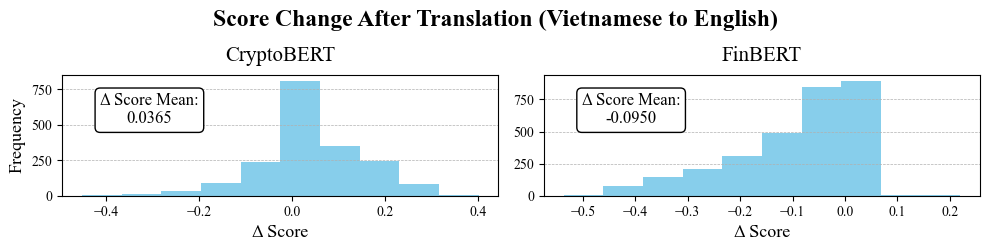

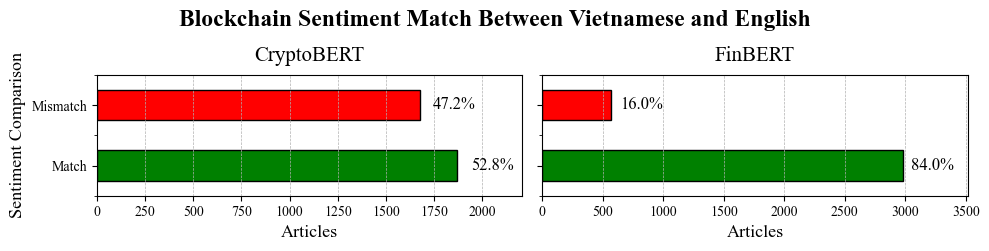

In [1]:
#THE CODE BELOW GENERATES FIGURE 1 AND 2, CORRESPECTIVELY, IN THE PAPER

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

def plot_diff_score_histograms(dfs, titles):
    plt.figure(figsize=(10, 3))
    for i, (df, title) in enumerate(zip(dfs, titles)):
        plt.subplot(1, 2, i + 1)
        plt.hist(df["diff_score"], bins=10, color="skyblue")
        avg = df["diff_score"].mean()
        plt.gca().text(0.2, 0.85, f"Δ Score Mean:\n{avg:.4f}", transform=plt.gca().transAxes,
                       fontsize=12, ha='center', va='top',
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        plt.title(title, fontsize=15, pad=10)
        plt.xlabel("Δ Score", fontsize=13)
        if i == 0:
            plt.ylabel("Frequency", fontsize=13)
        plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.suptitle("Score Change After Translation (Vietnamese to English)", fontsize=17, fontweight="bold", y=0.85)
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

def plot_sentiment_match_bars(dfs, titles):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    fig.suptitle("Blockchain Sentiment Match Between Vietnamese and English", 
                 fontsize=17, fontweight="bold", y=0.85)
    
    for ax, df, title in zip(axes, dfs, titles):
        counts = (df["vn_sent"] == df["en_sent"]).value_counts() \
                     .rename({True: "Match", False: "Mismatch"}) \
                     .reindex(["Match", "Mismatch"])
        
        colors = ["green", "red"]
        bars = counts.plot(kind="barh", color=colors, edgecolor="black", ax=ax)

        total = counts.sum()
        for i, value in enumerate(counts):
            ax.text(value + (0.02 * total), i, f"{(value/total)*100:.1f}%", 
                    va='center', fontsize=12, ha="left")  # always outside to the right

        ax.set_title(title, fontsize=15, pad=10)
        ax.set_xlabel("Articles", fontsize=13)
        ax.grid(axis="x", linestyle="--", linewidth=0.5)
        ax.set_xlim(0, max(counts.fillna(0).values) * 1.18)  
    
    axes[0].set_ylabel("Sentiment Comparison", fontsize=13)
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()


def filter_same_sentiment(df_a, df_b):
    df_a = df_1[df_1["vn_sent"] == df_1["en_sent"]]
    df_b = df_2[df_2["vn_sent"] == df_2["en_sent"]]
    df_collected = [df_a, df_b]
    return df_collected

df_1 = pd.read_csv("Cryptobert/comparison/categorized_blockchain_merge.csv")
df_2 = pd.read_csv("Finbert/comparison/categorized_blockchain_merge.csv")
dfs = [df_1, df_2]
titles = ["CryptoBERT", "FinBERT"]

df_collected = filter_same_sentiment(df_1, df_2)
plot_diff_score_histograms(df_collected, titles)
plot_sentiment_match_bars(dfs, titles)

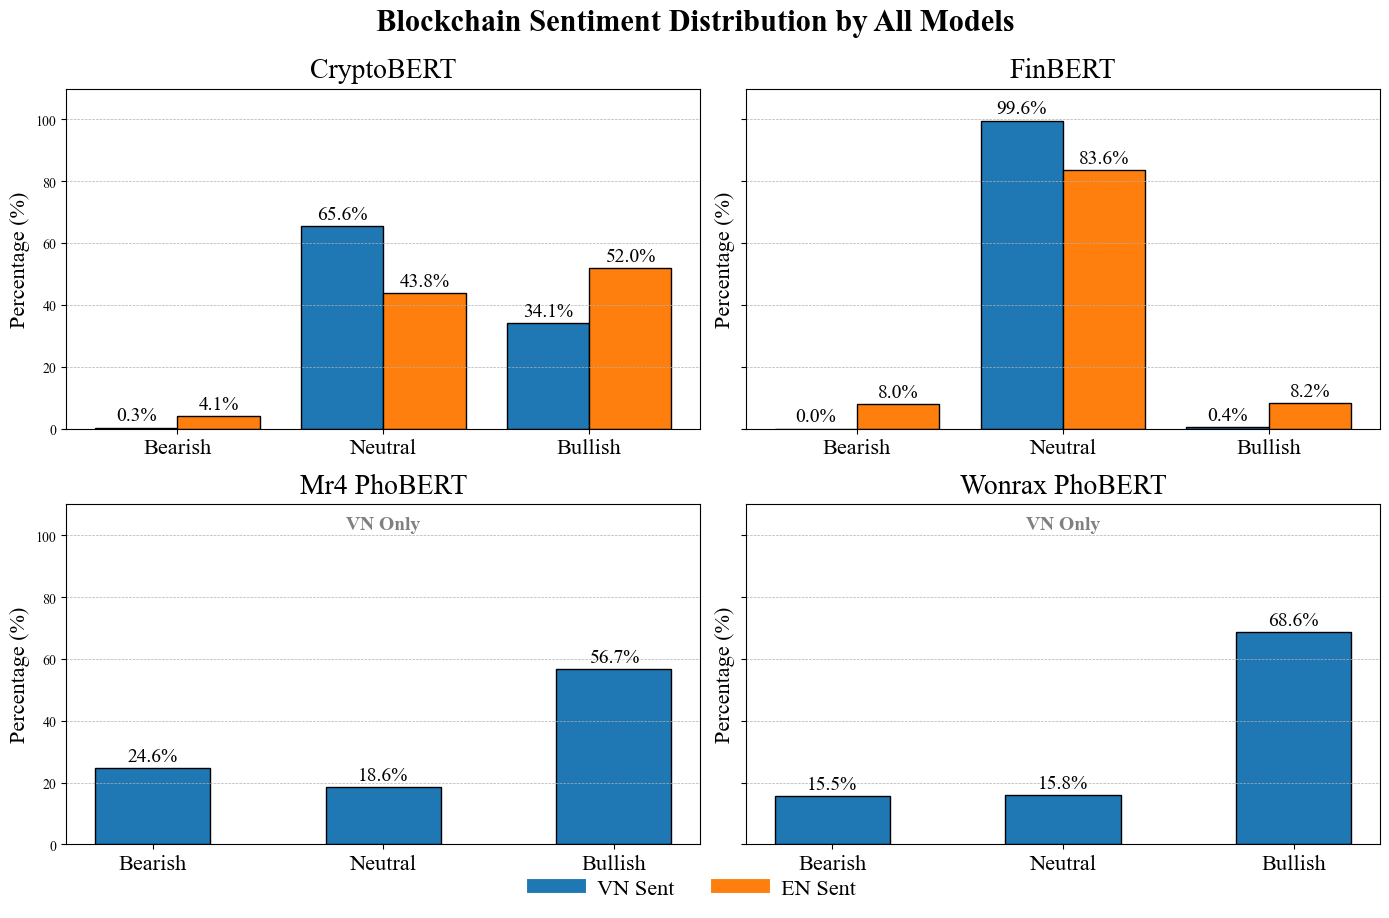

In [ ]:
#THE CODE BELOW GENERATES FIGURE 3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

def load_dataset_blockchain():
    df_1 = pd.read_csv("Cryptobert/comparison/categorized_blockchain_merge.csv")
    df_2 = pd.read_csv("Finbert/comparison/categorized_blockchain_merge.csv")
    df_3 = pd.read_csv("Mr4_Phobert/comparison/categorized_blockchain_merge.csv")
    df_4 = pd.read_csv("Wonrax_Phobert/comparison/categorized_blockchain_merge.csv")
    return df_1, df_2, df_3, df_4

def model_preprocessing(df_1, df_2, df_3, df_4):
    for df in (df_1, df_2, df_3, df_4):
        df["vn_sent"] = df["vn_sent"].astype(str).str.strip().str.lower()
    for df in (df_1, df_2):
        df["en_sent"] = df["en_sent"].astype(str).str.strip().str.lower()
    df_2["vn_sent"] = df_2["vn_sent"].replace({"negative": "bearish", "positive": "bullish"})
    df_2["en_sent"] = df_2["en_sent"].replace({"negative": "bearish", "positive": "bullish"})
    df_3["vn_sent"] = df_3["vn_sent"].replace({"tiêu cực": "bearish", "tích cực": "bullish", "trung tính": "neutral"})
    df_4["vn_sent"] = df_4["vn_sent"].replace({"negative": "bearish", "positive": "bullish"})
    return df_1, df_2, df_3, df_4

def plot_2x2(all_dfs, titles, sentiments):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    fig.suptitle("Blockchain Sentiment Distribution by All Models", fontsize=22, fontweight="bold", y=0.93)

    for ax, df, title in zip(axes.flatten(), all_dfs, titles):
        x = np.arange(len(sentiments))
        vn = df["vn_sent"].value_counts(normalize=True).reindex(sentiments, fill_value=0) * 100

        if "en_sent" in df.columns:
            en = df["en_sent"].value_counts(normalize=True).reindex(sentiments, fill_value=0) * 100
            bars1 = ax.bar(x, vn.values, width=0.4, color="#1f77b4", edgecolor="black", label="VN Sent")
            bars2 = ax.bar(x + 0.4, en.values, width=0.4, color="#ff7f0e", edgecolor="black", label="EN Sent")
            ax.set_xticks(x + 0.2)
        else:
            # single bar centered on label positions
            bars1 = ax.bar(x, vn.values, width=0.5, color="#1f77b4", edgecolor="black", label="VN Sent")
            ax.set_xticks(x)
            ax.text(1, 102, "VN Only", fontsize=14, fontweight="bold", color="gray", ha="center")

        # value labels
        for b in bars1:
            h = b.get_height()
            ax.text(b.get_x() + b.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=14)
        if "en_sent" in df.columns:
            for b in bars2:
                h = b.get_height()
                ax.text(b.get_x() + b.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=14)

        ax.set_title(title, fontsize=20, pad=8)
        ax.set_xticklabels(["Bearish", "Neutral", "Bullish"], fontsize=16)
        ax.set_ylim(0, 110)
        ax.set_ylabel("Percentage (%)", fontsize=16)
        ax.grid(axis="y", linestyle="--", linewidth=0.5)

    handles = [
        plt.Line2D([0], [0], color="#1f77b4", lw=10, label="VN Sent"),
        plt.Line2D([0], [0], color="#ff7f0e", lw=10, label="EN Sent")
    ]
    fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, 0.02),
               ncol=2, fontsize=16, frameon=False)

    plt.tight_layout(rect=[0, 0.05, 1, 0.94])
    plt.show()

df_1, df_2, df_3, df_4 = load_dataset_blockchain()
df_1, df_2, df_3, df_4 = model_preprocessing(df_1, df_2, df_3, df_4)

sentiments = ["bearish", "neutral", "bullish"]
plot_2x2(
    all_dfs=[df_1, df_2, df_3, df_4],
    titles=["CryptoBERT", "FinBERT", "Mr4 PhoBERT", "Wonrax PhoBERT"],
    sentiments=sentiments
)

In [ ]:
#FINAL PROCESSING BEFORE TIME-SERIES ANALYSIS
#remove all the rows that contain date before year 2018: which is when Vietnam passes the first cybersecurity law
#remove all the rows that have no valid date
#set the date format to YYYY-MM-DD
#sort the rows in order by date

import pandas as pd, re

df = pd.read_csv("Finbert/sentiment/vietnamnet_crypto.csv")

def fix_date(d):
    if pd.isna(d): return None
    d = str(d).strip()
    try: return pd.to_datetime(d, **({} if re.match(r"^\d{4}", d) else {"dayfirst": True})).strftime('%Y-%m-%d')
    except: return None

df['date'] = df['date'].apply(fix_date)
df = df[df['date'].notna()]
df = df[df['date'].str[:4].astype(int) >= 2018]
df = df.sort_values('date').reset_index(drop=True)
df.to_csv("Finbert/comparison/filtered_crypto.csv", index=False)

print(f"Rows remaining: {len(df)}")